In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [19]:
!pip install gender-guesser

In [21]:
import gender_guesser.detector as gender
gd = gender.Detector()

In [2]:
!pip install kaggle


In [5]:
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c spaceship-titanic
!unzip /content/spaceship-titanic.zip

  0% 0.00/299k [00:00<?, ?B/s]
100% 299k/299k [00:00<00:00, 61.3MB/s]
Archive:  /content/spaceship-titanic.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


#DATA Pre-Processing

In [7]:
data = pd.read_csv("train.csv")

In [8]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [9]:
data[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)

0           0.0
1         736.0
2       10383.0
3        5176.0
4        1091.0
         ...   
8688     8536.0
8689        0.0
8690     1873.0
8691     4637.0
8692     4826.0
Length: 8693, dtype: float64

In [10]:
data['Cabin']

0          B/0/P
1          F/0/S
2          A/0/S
3          A/0/S
4          F/1/S
          ...   
8688      A/98/P
8689    G/1499/S
8690    G/1500/S
8691     E/608/S
8692     E/608/S
Name: Cabin, Length: 8693, dtype: object

In [11]:
def get_second(x):
  try:
    return str(x).split('/')[1]
  except:
    return '0'
def get_third(x):
  try:
    return str(x).split('/')[2]
  except:
    return '0'

In [22]:
data['cabin_1']= data.Cabin.apply(lambda x:str(x).split('/')[0])
data['cabin_2']= data.Cabin.apply(get_second)
data['cabin_3']= data.Cabin.apply(get_third)
data['group'] = data.PassengerId.apply(lambda x:int(x.split('_')[0]))
data['pos'] = data.PassengerId.apply(lambda x:int(x.split('_')[1]))
data['Total'] = data[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)
data["HPDE"] = data['HomePlanet'] + data['Destination']
data['Gender'] = data['Name'].apply(gd.get_gender)
data['HomePlanet'] = le.fit_transform(data['HomePlanet'])
data['Destination'] = le.fit_transform(data['Destination'])
data['HPDE'] = le.fit_transform(data['HPDE'])
data['Gender'] = le.fit_transform(data['Gender'])
data['cabin_1'] = le.fit_transform(data['cabin_1'])
data['cabin_2'] = le.fit_transform(data['cabin_2'])
data['cabin_3'] = le.fit_transform(data['cabin_3'])

In [24]:
data.drop(['Cabin','Name'],axis=1,inplace=True)

In [25]:
cols = data.columns

In [26]:
col = list(cols)
col.remove('Transported')
col

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Destination',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'cabin_1',
 'cabin_2',
 'cabin_3',
 'group',
 'pos',
 'Total',
 'HPDE',
 'Gender']

In [28]:
# processed = data.fillna(-1)
imputer = KNNImputer(n_neighbors=5)
processed = pd.DataFrame(imputer.fit_transform(data.drop(['Transported'],axis=1)),columns=col)

In [29]:
processed[['CryoSleep','VIP']] = processed[['CryoSleep','VIP']].applymap(int)

#Data Exploration

In [21]:
import seaborn as sns
%matplotlib inline

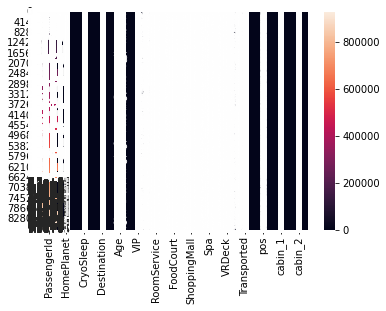

In [23]:
sns.heatmap(processed, annot=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f722cf9e210>,
      dtype=object)

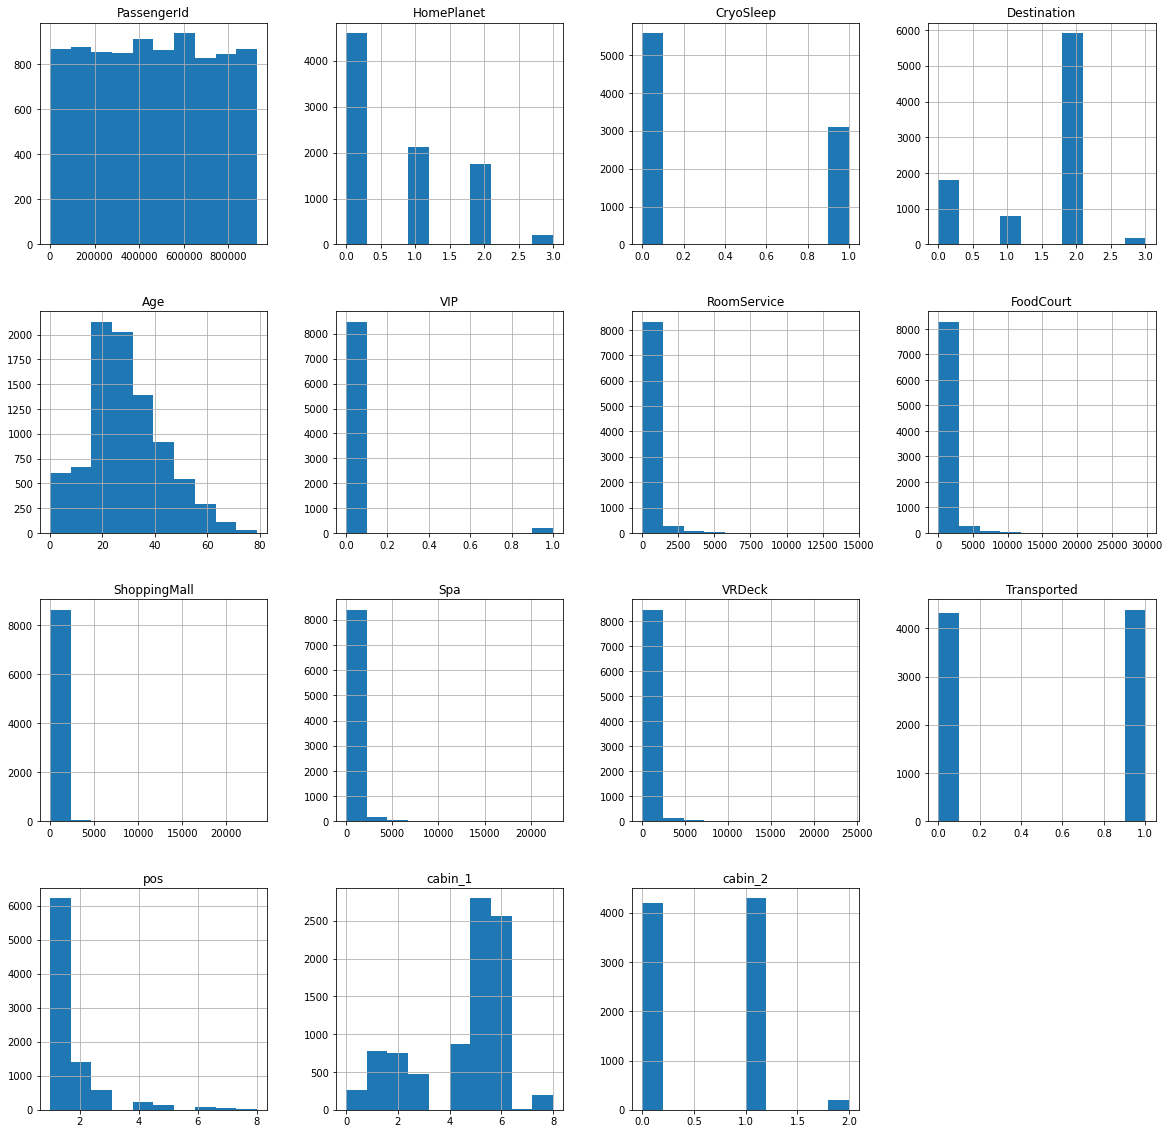

In [38]:
processed.hist(figsize=(20,20))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f72278ce410>,
      dtype=object)

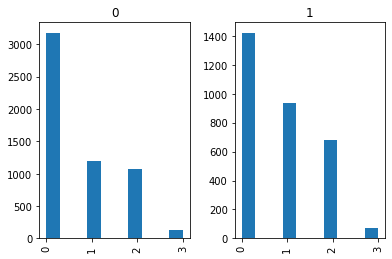

In [53]:
processed['HomePlanet'].hist(by=processed['CryoSleep'])

In [30]:
processed.drop(['PassengerId'],inplace=True,axis=1)

In [31]:
from sklearn.model_selection import train_test_split, StratifiedKFold

In [32]:
y = data['Transported'].apply(bool)
X = processed
cols2 = X.columns

In [312]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(X),columns=cols2)
# X = sc.transform(X)
print(X)

      HomePlanet  CryoSleep  Destination       Age       VIP  RoomService  \
0       0.325245  -0.743743     0.577024  0.707465 -0.153063    -0.336984   
1      -0.833031  -0.743743     0.577024 -0.332228 -0.153063    -0.172360   
2       0.325245  -0.743743     0.577024  2.024410  6.533255    -0.272041   
3       0.325245  -0.743743     0.577024  0.291588 -0.153063    -0.336984   
4      -0.833031  -0.743743     0.577024 -0.886731 -0.153063     0.120639   
...          ...        ...          ...       ...       ...          ...   
8688    0.325245  -0.743743    -1.803647  0.846091  6.533255    -0.336984   
8689   -0.833031   1.344551    -0.613311 -0.748106 -0.153063    -0.336984   
8690   -0.833031  -0.743743     0.577024 -0.193602 -0.153063    -0.336984   
8691    0.325245  -0.743743    -1.803647  0.222275 -0.153063    -0.336984   
8692    0.325245  -0.743743     0.577024  1.054030 -0.153063    -0.146685   

      FoodCourt  ShoppingMall       Spa    VRDeck   cabin_1   cabin_2  \
0 

In [57]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [62]:
X

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,cabin_1,cabin_2,cabin_3,group,pos,Total,HPDE,Gender
0,1.0,0,2.0,39.0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0
1,0.0,0,2.0,24.0,0,109.0,9.0,25.0,549.0,44.0,5.0,0.0,2.0,2.0,1.0,736.0,2.0,0.0
2,1.0,0,2.0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0.0,0.0,2.0,3.0,1.0,10383.0,3.0,0.0
3,1.0,0,2.0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0.0,0.0,2.0,3.0,2.0,5176.0,3.0,0.0
4,0.0,0,2.0,16.0,0,303.0,70.0,151.0,565.0,2.0,5.0,1.0,2.0,4.0,1.0,1091.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,1.0,0,0.0,41.0,1,0.0,6819.0,0.0,1643.0,74.0,0.0,1795.0,1.0,9276.0,1.0,8536.0,1.0,0.0
8689,0.0,1,1.0,18.0,0,0.0,0.0,0.0,0.0,0.0,6.0,548.0,2.0,9278.0,1.0,0.0,1.0,0.0
8690,0.0,0,2.0,26.0,0,0.0,0.0,1872.0,1.0,0.0,6.0,551.0,2.0,9279.0,1.0,1873.0,2.0,0.0
8691,1.0,0,0.0,32.0,0,0.0,1049.0,0.0,353.0,3235.0,4.0,1385.0,2.0,9280.0,1.0,4637.0,1.0,0.0



#Random forest prediction

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

##Training

In [58]:
def RFTrain(k=15,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test,r_state=0):
  clf = RandomForestClassifier(max_depth=k, random_state=r_state)
  clf1 = clf.fit(X_train,y_train)
  acc= clf.score(X_test,y_test)
  # print(f"Accuracy for max_depth = {i} is {acc}")
  return acc

In [60]:
for i in range(10,25):
   print(f"Accuracy for depth = {i} iS {RFTrain(k=i)}")

Accuracy for depth = 10 iS 0.7998849913743531
Accuracy for depth = 11 iS 0.7998849913743531
Accuracy for depth = 12 iS 0.7993099482461185
Accuracy for depth = 13 iS 0.7958596894767107
Accuracy for depth = 14 iS 0.7998849913743531
Accuracy for depth = 15 iS 0.7947096032202415
Accuracy for depth = 16 iS 0.79700977573318
Accuracy for depth = 17 iS 0.7975848188614146
Accuracy for depth = 18 iS 0.7935595169637722
Accuracy for depth = 19 iS 0.7975848188614146
Accuracy for depth = 20 iS 0.7947096032202415
Accuracy for depth = 21 iS 0.7998849913743531
Accuracy for depth = 22 iS 0.7981598619896493
Accuracy for depth = 23 iS 0.7998849913743531
Accuracy for depth = 24 iS 0.7993099482461185


In [41]:
def train_RF_wrap(rstate=0,r_state = 111,splits=3):
  y_probs = []
  val = []
  folds = StratifiedKFold(n_splits = splits, shuffle=True, random_state=rstate)
  for fold, (train_id, test_id) in enumerate(folds.split(X, y)): 
    # print("fold : ", fold + 1, end = ' ')
  # Split data
    X_train = X.iloc[train_id]
    y_train = y.iloc[train_id]
    X_valid = X.iloc[test_id]
    y_valid = y.iloc[test_id]
    k = 1
    mx = 0
    for i in range(1,25):
      acc = RFTrain(i,X_train=X_train,y_train=y_train,X_test=X_valid,y_test=y_valid,r_state=r_state)
      if acc > mx:
        k = i
        mx = acc
    # Train RF
    model =  RandomForestClassifier(max_depth=k, random_state=r_state)
    model.fit(X_train, y_train)

    # Print validation score to see how it works
    valid_pred = model.predict(X_valid)
    valid_score = accuracy_score(y_valid, valid_pred)
    # print( "Validation score: ", valid_score, end = ' ')
    val.append(valid_score)
    # test
    y_probs.append(model.predict_proba(testData))
  return val,y_probs

###Gridsearch


In [47]:
r_state = 111
val_m = 0
rstate_val = 0
y_probs_m = []
for j in range(5,105,10):
  val,y_probs = train_RF_wrap(rstate=j)
  if np.average(val)> val_m:
    y_probs_m = y_probs
    val_m = np.average(val)


In [48]:
val_m

0.8072019323989128

##Prediction

In [49]:
predicted = np.argmax(np.sum(np.array(y_probs_m),axis=0),axis=1)

In [ ]:
predicted = np.argmax(np.average(np.array(y_probs_m),axis=0,weights=[3,1,2,2,1]),axis=1)

In [43]:
def preProcess(data):
  data['cabin_1']= data.Cabin.apply(lambda x:str(x).split('/')[0])
  data['cabin_2']= data.Cabin.apply(get_second)
  data['cabin_3']= data.Cabin.apply(get_third)
  data['group'] = data.PassengerId.apply(lambda x:int(x.split('_')[0]))
  data['pos'] = data.PassengerId.apply(lambda x:int(x.split('_')[1]))
  data['Total'] = data[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)
  data["HPDE"] = data['HomePlanet'] + data['Destination']
  data['Gender'] = data['Name'].apply(gd.get_gender)
  data['HomePlanet'] = le.fit_transform(data['HomePlanet'])
  data['Destination'] = le.fit_transform(data['Destination'])
  data['HPDE'] = le.fit_transform(data['HPDE'])
  data['Gender'] = le.fit_transform(data['Gender'])
  data['cabin_1'] = le.fit_transform(data['cabin_1'])
  data['cabin_2'] = le.fit_transform(data['cabin_2'])
  data['cabin_3'] = le.fit_transform(data['cabin_3'])
  data.drop(['Cabin','Name'],axis=1,inplace=True)
  # processed = data.fillna(-1)
  processed = pd.DataFrame(imputer.transform(data),columns=col)
  processed[['CryoSleep','VIP']] = processed[['CryoSleep','VIP']].applymap(int)
  processed.drop(['PassengerId'],inplace=True,axis=1)
  return processed

In [44]:
testdata = pd.read_csv('test.csv')
testData= preProcess(testdata)

In [ ]:
testData

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,pos,cabin_1,cabin_2
0,0013_01,0,1,2,27.0,0,0.0,0.0,0.0,0.0,0.0,1,6,1
1,0018_01,0,0,2,19.0,0,0.0,9.0,0.0,2823.0,0.0,1,5,1
2,0019_01,1,1,0,31.0,0,0.0,0.0,0.0,0.0,0.0,1,2,1
3,0021_01,1,0,2,38.0,0,0.0,6652.0,0.0,181.0,585.0,1,2,1
4,0023_01,0,0,2,20.0,0,10.0,0.0,635.0,0.0,0.0,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,0,1,2,34.0,0,0.0,0.0,0.0,0.0,0.0,2,6,1
4273,9269_01,0,0,2,42.0,0,0.0,847.0,17.0,10.0,144.0,1,8,2
4274,9271_01,2,1,0,-1.0,0,0.0,0.0,0.0,0.0,0.0,1,3,0
4275,9273_01,1,0,3,-1.0,0,0.0,2680.0,0.0,0.0,523.0,1,3,0


In [ ]:
predicted = clf.predict(testData)

In [ ]:
len(predicted)

4277

##Submission

In [51]:
testData

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,cabin_1,cabin_2,cabin_3,group,pos,Total,HPDE,Gender
0,0.0,1,2.0,27.0,0,0.0,0.0,0.0,0.0,0.0,6.0,820.0,2.0,13.0,1.0,0.0,2.0,0.0
1,0.0,0,2.0,19.0,0,0.0,9.0,0.0,2823.0,0.0,5.0,927.0,2.0,18.0,1.0,2832.0,2.0,0.0
2,1.0,1,0.0,31.0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,19.0,1.0,0.0,3.0,0.0
3,1.0,0,2.0,38.0,0,0.0,6652.0,0.0,181.0,585.0,2.0,1.0,2.0,21.0,1.0,7418.0,5.0,0.0
4,0.0,0,2.0,20.0,0,10.0,0.0,635.0,0.0,0.0,5.0,1029.0,2.0,23.0,1.0,645.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,0.0,1,2.0,34.0,0,0.0,0.0,0.0,0.0,0.0,6.0,452.0,2.0,9266.0,2.0,0.0,2.0,0.0
4273,0.0,0,2.0,42.0,0,0.0,847.0,17.0,10.0,144.0,8.0,0.0,0.0,9269.0,1.0,1018.0,2.0,0.0
4274,2.0,1,0.0,25.6,0,0.0,0.0,0.0,0.0,0.0,3.0,816.0,1.0,9271.0,1.0,0.0,6.0,0.0
4275,1.0,0,3.0,35.8,0,0.0,2680.0,0.0,0.0,523.0,3.0,817.0,1.0,9273.0,1.0,3203.0,9.0,0.0


In [52]:
testData2 = pd.DataFrame(testdata['PassengerId'])
testData2['Transported'] = predicted
testData2['Transported'] = testData2.Transported.apply(bool)

In [53]:
testData2

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [54]:
testData2.to_csv("result.csv",index=False)

In [55]:
!kaggle competitions submit -c spaceship-titanic -f result.csv -m "Submission with cross validated probability ensemble and gridsearched max_depth, basic pre-processing"

100% 56.4k/56.4k [00:00<00:00, 134kB/s]
Successfully submitted to Spaceship Titanic

In [ ]:
res = pd.read_csv("result.csv")

In [ ]:
res['Transported'] = res.Transported.apply(bool)

In [ ]:
res

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [ ]:
res.to_csv('result.csv',index=False)

#Naive Bayes Prediction

In [ ]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

In [ ]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
correct = (y_test == y_pred).sum()
print("Number of correct points out of a total %d points : %d"
       % (X_test.shape[0], correct))
print(f"Accuracy is {correct/len(y_pred)}")

Number of correct points out of a total 1739 points : 1189
Accuracy is 0.6837262794709603


In [ ]:
mnb = MultinomialNB()
y_pred = mnb.fit(X_train, y_train).predict(X_test)
correct = (y_test == y_pred).sum()
print("Number of correct points out of a total %d points : %d"
       % (X_test.shape[0], correct))
print(f"Accuracy is {correct/len(y_pred)}")

Number of correct points out of a total 1739 points : 1268
Accuracy is 0.7291546866014951


#XGBoost Prediction

In [115]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

##Training

In [326]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 15, alpha = 10, n_estimators = 10)

In [327]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

In [328]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.430768


In [329]:
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

In [330]:

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

In [331]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.5,'learning_rate': 0.05,
                'max_depth': 25, 'alpha': 5}
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=1000)

In [332]:
def accuracy_xgboost(data_dmatrix=data_dmatrix,model = xg_reg,y=y_train):
  y_pred = model.predict(data = data_dmatrix)
  predictions = [round(value) for value in y_pred]
  y_pred = list(map(int,y_pred>0.5))
  # print(len(y_pred))
  # evaluate predictions
  accuracy = accuracy_score(y, predictions)
  print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [333]:
accuracy_xgboost()

Accuracy: 91.93%


In [334]:
data_dmatrix_2 = xgb.DMatrix(data=X_test,label=y_test)

In [335]:
accuracy_xgboost(data_dmatrix=data_dmatrix_2,y=y_test)

Accuracy: 81.37%


## Prediction

In [354]:
data_dmatrix_3 = xgb.DMatrix(data=testData)

In [355]:
y_pred = xg_reg.predict(data = data_dmatrix_3)
predictions = [round(value) for value in y_pred]
y_pred = y_pred>0.5

In [357]:
len(y_pred)

4277

##Submission

In [360]:
predicted_df = pd.DataFrame(testdata['PassengerId'])

In [361]:
predicted_df['Transported'] = y_pred

In [362]:
predicted_df

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,False


In [363]:
predicted_df.to_csv('result_xg.csv',index=False)

In [364]:
!kaggle competitions submit -c spaceship-titanic -f result_xg.csv -m "Submission with finetuned xgboost, added feature engineering in  pre-processing"

100% 56.8k/56.8k [00:02<00:00, 21.9kB/s]
Successfully submitted to Spaceship Titanic

In [345]:
predicted_df

,Transported,PassengerId
0,True,0001_01
1,False,0002_01
2,False,0003_01
3,False,0003_02
4,False,0004_01
...,...,...
4272,True,4549_01
4273,False,4550_01
4274,True,4552_01
4275,False,4553_01


In [346]:
pd.read_csv('result_xg.csv')

,Transported,PassengerId
0,True,0001_01
1,False,0002_01
2,False,0003_01
3,False,0003_02
4,False,0004_01
...,...,...
4272,True,4549_01
4273,False,4550_01
4274,True,4552_01
4275,False,4553_01
